In [2]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)


Data downloaded. Shape: (30000, 25)
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4']
Logistic Regression ROC AUC: 0.7081
0:	test: 0.7528729	best: 0.7528729 (0)	total: 59.5ms	remaining: 17.8s
50:	test: 0.7745377	best: 0.7745377 (50)	total: 639ms	remaining: 3.12s
100:	test: 0.7791794	best: 0.7791794 (100)	total: 1.19s	remaining: 2.35s
150:	test: 0.7807218	best: 0.7807702 (140)	total: 1.77s	remaining: 1.75s
200:	test: 0.7809761	best: 0.7812510 (174)	total: 2.32s	remaining: 1.14s
250:	test: 0.7818069	best: 0.7818956 (239)	total: 2.92s	remaining: 569ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.781895579
bestIteration = 239

Shrink model to first 240 iterations.
CatBoost ROC AUC: 0.7819
Logistic best threshold: 0.985, cost: 66200.0
CatBoost best threshold: 0.906, cost: 66100.0


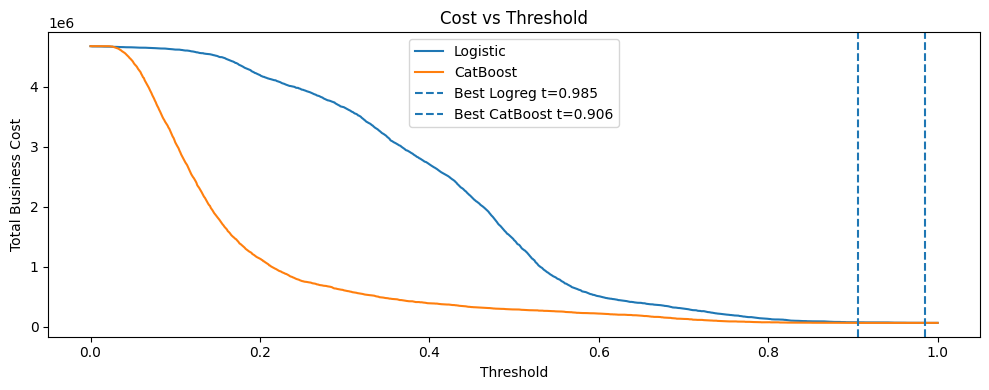


Logistic Evaluation at Optimal Threshold:
              precision    recall  f1-score   support

           0     0.7792    1.0000    0.8759      4673
           1     1.0000    0.0023    0.0045      1327

    accuracy                         0.7793      6000
   macro avg     0.8896    0.5011    0.4402      6000
weighted avg     0.8281    0.7793    0.6832      6000

ROC AUC: 0.7081

CatBoost Evaluation at Optimal Threshold:
              precision    recall  f1-score   support

           0     0.7795    1.0000    0.8761      4673
           1     1.0000    0.0038    0.0075      1327

    accuracy                         0.7797      6000
   macro avg     0.8897    0.5019    0.4418      6000
weighted avg     0.8283    0.7797    0.6840      6000

ROC AUC: 0.7819


In [6]:


import numpy as np
import pandas as pd
from io import BytesIO
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
print("Downloading dataset…")
resp = requests.get(url)
resp.raise_for_status()

# The first row is header; load with pandas
df = pd.read_excel(BytesIO(resp.content), header=1)
df.rename(columns={'default payment next month': 'TARGET'}, inplace=True)


print("Data downloaded. Shape:", df.shape)
print("Columns:", df.columns.tolist()[:10])

# Preprocessing

target = "TARGET"
X = df.drop(columns=[target, 'ID']) if 'ID' in df.columns else df.drop(columns=[target])
y = df[target]

# Simple numeric preprocessing: fill missing if any
X = X.fillna(X.median())
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
logreg.fit(X_train_s, y_train)
probs_log = logreg.predict_proba(X_val_s)[:, 1]
auc_log = roc_auc_score(y_val, probs_log)
print(f"Logistic Regression ROC AUC: {auc_log:.4f}")

# CatBoost
cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=50,
    early_stopping_rounds=30
)
cat.fit(Pool(X_train, y_train), eval_set=Pool(X_val, y_val))
probs_cat = cat.predict_proba(X_val)[:, 1]
auc_cat = roc_auc_score(y_val, probs_cat)
print(f"CatBoost ROC AUC: {auc_cat:.4f}")

# Cost-based threshold optimization
cost_fp = 1000.0  # cost of approving a defaulter
cost_fn = 50.0    # cost (opportunity) of rejecting a good client

def find_best_threshold(probs, y_true, cost_fp, cost_fn, model_name="model"):
    thresholds = np.linspace(0, 1, 1001)
    costs = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        total_cost = fp * cost_fp + fn * cost_fn
        costs.append(total_cost)
    best_idx = np.argmin(costs)
    return thresholds[best_idx], costs[best_idx], thresholds, costs

best_t_log, best_cost_log, thr_log, costs_log = find_best_threshold(probs_log, y_val, cost_fp, cost_fn, "Logistic")
best_t_cat, best_cost_cat, thr_cat, costs_cat = find_best_threshold(probs_cat, y_val, cost_fp, cost_fn, "CatBoost")

print(f"Logistic best threshold: {best_t_log:.3f}, cost: {best_cost_log}")
print(f"CatBoost best threshold: {best_t_cat:.3f}, cost: {best_cost_cat}")

# Plot cost curves
plt.figure(figsize=(10,4))
plt.plot(thr_log, costs_log, label='Logistic')
plt.plot(thr_cat, costs_cat, label='CatBoost')
plt.axvline(best_t_log, linestyle='--', label=f'Best Logreg t={best_t_log:.3f}')
plt.axvline(best_t_cat, linestyle='--', label=f'Best CatBoost t={best_t_cat:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Total Business Cost')
plt.title('Cost vs Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation at optimal thresholds
def evaluate(probs, y_true, threshold):
    preds = (probs >= threshold).astype(int)
    print(classification_report(y_true, preds, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_true, probs):.4f}")

print("\nLogistic Evaluation at Optimal Threshold:")
evaluate(probs_log, y_val, best_t_log)
print("\nCatBoost Evaluation at Optimal Threshold:")
evaluate(probs_cat, y_val, best_t_cat)

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
